In [1]:
import tensorflow as tf
import numpy as np

# 8.1 텐서플로 허브에서 사전 훈련된 MobileNet 모델 불러오기
import tensorflow_hub as hub

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([
    hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3), trainable=False)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


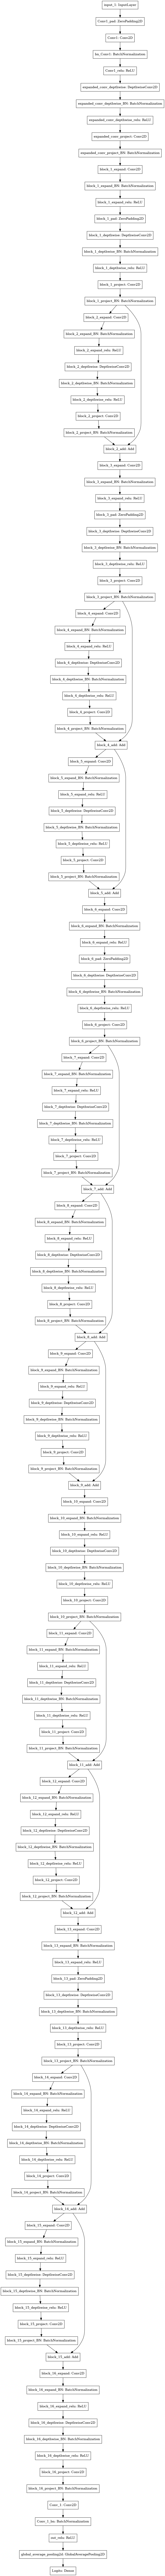

In [2]:
# 그림 8.2 좌측 전체 네트워크 구조 출력 코드
try:
    import pydot_ng as pydot
except ImportError:
    pydot = None
import graphviz

from tensorflow.keras.applications import MobileNetV2

mobilev2 = MobileNetV2()
tf.keras.utils.plot_model(mobilev2)

In [3]:
# 8.2 ImageNetV2-TopImages 불러오기
import os
import pathlib
data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-topimages.tar.gz', extract=True)
data_root = pathlib.Path('/root/.keras/datasets/imagenetv2-top-images-format-val')
print(data_root)

/root/.keras/datasets/imagenetv2-top-images-format-val


In [4]:
# 8.3 디렉토리 출력
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

/root/.keras/datasets/imagenetv2-top-images-format-val/874
/root/.keras/datasets/imagenetv2-top-images-format-val/300
/root/.keras/datasets/imagenetv2-top-images-format-val/699
/root/.keras/datasets/imagenetv2-top-images-format-val/299
/root/.keras/datasets/imagenetv2-top-images-format-val/412
/root/.keras/datasets/imagenetv2-top-images-format-val/789
/root/.keras/datasets/imagenetv2-top-images-format-val/806
/root/.keras/datasets/imagenetv2-top-images-format-val/453
/root/.keras/datasets/imagenetv2-top-images-format-val/849
/root/.keras/datasets/imagenetv2-top-images-format-val/880


In [5]:
# 8.4 ImageNet 라벨 텍스트 불러오기
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


image_count: 10000


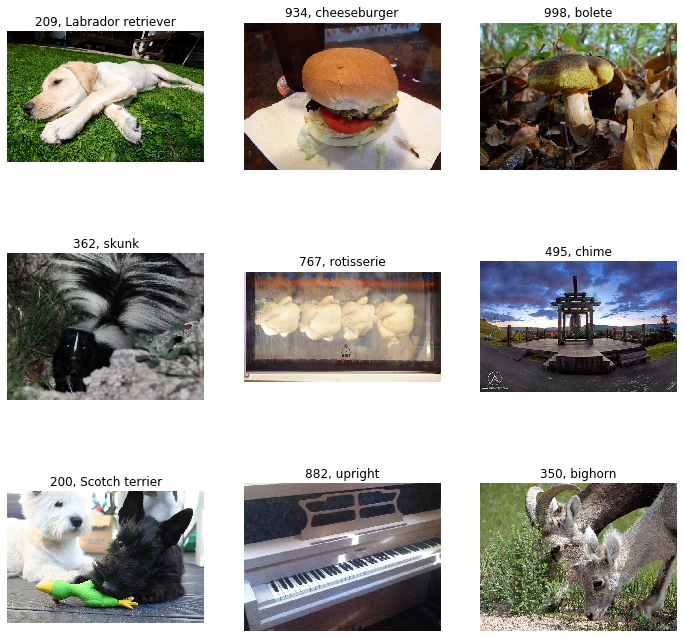

In [11]:
# 8.5 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
# 이미지를 랜덤하게 섞습니다.
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
plt.show()

In [ ]:
# 8.6 MobileNet의 분류 성능 확인
import cv2

top_1 = 0
top_5 = 0
for image_path in all_image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    top_5_predict = model.predict(img)[0].argsort()[::-1][:5]
    idx = int(image_path.split('/')[-2])+1
    if idx in top_5_predict:
        top_5 += 1
        if top_5_predict[0] == idx:
            top_1 += 1

print('Top-5 correctness:', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 correctness:', top_1 / len(all_image_paths) * 100, '%')

In [ ]:
# numpy.argsort() 설명 코드
a = np.array([99,32,5,64])
arg = np.argsort(a)
print(arg)
print(np.sort(a))
print(a[arg])

In [ ]:
# 8.7 MobileNet의 분류 라벨 확인
plt.figure(figsize=(16,16))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
  
for c in range(3):
    image_path = random.choice(all_image_paths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # MobileNet을 이용한 예측
    logits = model.predict(img)[0]
    prediction = softmax(logits)
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [label_text[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])    

In [ ]:
# 8.8 Stanford Dog Dataset을 Kaggle에서 불러오기

# 2020.02.01 현재 kaggle의 Stanford Dog Dataset 파일 구조가 변경되었습니다. 
# kaggle API를 사용하는 대신에 아래 링크에서 파일을 직접 받아오도록 수정되었습니다.
tf.keras.utils.get_file('labels.csv', 'http://bit.ly/2GDxsYS')
tf.keras.utils.get_file('sample_submission.csv', 'http://bit.ly/2GGnMNd')
tf.keras.utils.get_file('train.zip', 'http://bit.ly/31nIyel')
tf.keras.utils.get_file('test.zip', 'http://bit.ly/2GHEsnO')

import os
os.environ['KAGGLE_USERNAME'] = 'user_id' # 독자의 캐글 ID
os.environ['KAGGLE_KEY'] = 'user_api_token' # 독자의 캐글 API Token
# !kaggle competitions download -c dog-breed-identification

In [ ]:
# 8.9 파일의 압축 풀기
# !unzip train.zip
# !unzip labels.csv.zip

In [ ]:
# 8.10 labels.csv 파일 내용 확인
import pandas as pd
label_text = pd.read_csv('/root/.keras/datasets/labels.csv')
print(label_text.head())

In [ ]:
# 8.11 labels.csv 정보 확인
label_text.info()

In [ ]:
# 8.12 견종 수 확인
label_text['breed'].nunique()

In [ ]:
# 8.13 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
    image_id = label_text.loc[c, 'id']
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread('/root/.keras/datasets/train/' + image_id + '.jpg'))
    plt.title(str(c) + ', ' + label_text.loc[c, 'breed'])
    plt.axis('off')
plt.show()

In [ ]:
# 8.14 tf.keras에서 MobileNet V2 불러오기
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

In [ ]:
import tensorflow as tf
import numpy as np
# 8.15 MobileNet V2의 가중치 초기화
for layer in mobilev2.layers[:-1]:
    layer.trainable = True
    
for layer in mobilev2.layers[:-1]: 
    if 'kernel' in layer.__dict__:
        kernel_shape = np.array(layer.get_weights()).shape
        # weight를 평균이 0, 표준편차가 1인 random 변수로 초기화
        layer.set_weights(tf.random.normal(kernel_shape, 0, 1)) 

In [ ]:
# 8.24 ImageDataGenerator가 처리할 수 있는 하위 디렉토리 구조로 데이터 복사
import os
import shutil

os.mkdir('/tf/content/train_sub')

for i in range(len(label_text)):
    if os.path.exists('/tf/content/train_sub/' + label_text.loc[i]['breed']) == False:
        os.mkdir('/tf/content/train_sub/' + label_text.loc[i]['breed'])
    shutil.copy('/tf/content/train/' + label_text.loc[i]['id'] + '.jpg', '/content/train_sub/' + label_text.loc[i]['breed'])

# 8.25 ImageDataGenerator를 이용한 train/validation 데이터 분리, Image Augmentation
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 224 # 이미지 사이즈가 299에서 224로 바뀌었습니다.
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

train_generator = train_datagen.flow_from_directory(directory="/tf/content/train_sub/", subset="training", batch_size=batch_size, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))
valid_generator = valid_datagen.flow_from_directory(directory="/tf/content/train_sub/", subset="validation", batch_size=1, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))